# Tratamento de dados

## Importanto o dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

df = pd.read_csv('diabetes.csv')

# Random State
RS = 0

Agora vamos estudar um pouco sobre os dados existentes no dataset de diabetes.

## Estudando os dados

In [2]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Com essa breve analise podemos observar que alguns valores, como pressão sanguinea e IMC, são iguais a 0, e esse resultado é impossível na vida real, por ser um valor que não teria como obter em uma pessoa. Então esse valor igual a 0 poderia afetar a presição dos modelos utilizados.

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
all_values = df.count()
missing_values = df[(df['BMI'] == 0) | (df['SkinThickness'] == 0) | (df['BloodPressure'] == 0)].count()
not_missing_values = df[(df['BMI'] != 0) & (df['SkinThickness'] != 0) & (df['BloodPressure'] != 0)].count()

print(f'Temos no total {all_values["Outcome"]} linhas e removendo as que possuem valores iguais a zero teriamos: {not_missing_values["Outcome"]}')

Temos no total 768 linhas e removendo as que possuem valores iguais a zero teriamos: 537


Para aumentar a precisão do nosso modelo temos 3 opções:

- Deletar os valores faltantes
- Inserir um valor igual a média daquela coluna
- Inserir um valor igual a média daquela coluna e criar uma nova coluna que diz se o valor for inserido ou não

Então vamos testar todas elas e escolher a melhor para o nosso caso...

## Tratamento dos dados faltantes

### Função que analisará cada opção

Essa função irá nos ajudar a escolher o melhor método de tratamento de valores faltantes.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators=15, random_state=RS)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    
    list_y_valid = y_valid.tolist()
    
    plot_confusion_matrix(model, X_valid, y_valid, cmap = "cool")
    plt.grid(False)
    plt.show()
    
    return balanced_accuracy_score(y_valid, preds)

Obs.: para realizar o teste iremos utilizar o modelo RandomForestRegressor, pode não ser o melhor modelo para nosso dataset, mas é suficiente para testar qual é a melhor opção nesse caso.

Antes de iniciar vamos importar uma função para separar os dados em validação e testes:

In [5]:
from sklearn.model_selection import train_test_split

### Remover valores faltantes

Agora vamos remover as linhas que possuem valores iguais a 0, separaremos e depois iremos testar o desempenho.

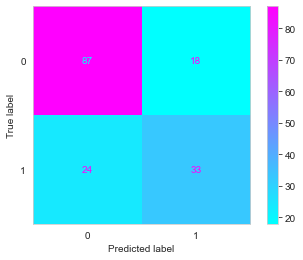

Accuracy: 70.38%


In [6]:
non_zero_df = df[(df['BMI'] != 0) & (df['SkinThickness'] != 0) & (df['BloodPressure'] != 0)]

y = non_zero_df["Outcome"]
X = non_zero_df.drop(["Outcome"], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=RS)

print("Accuracy: " + str(round(score_dataset(X_train, X_valid, y_train, y_valid)*100, 2)) + "%")

### Inserir valor médio para aquela coluna

Agora iremos utilizar a segunda técnica que é trocar o NaN pela média da coluna atual

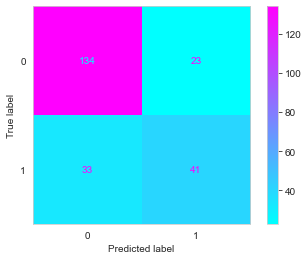

Accuracy:70.38%


In [7]:
y = df.Outcome
X = df.drop(["Outcome"], axis=1)

# Change all 0 to NaN
X.replace(0, np.nan, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=RS)

from sklearn.impute import SimpleImputer
# Imputing data in df
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))
# Putting column names back to the imputed df
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("Accuracy:" + str(round(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid)*100, 2)) + "%")

### Inserindo valor médio da coluna e indicando que o valor foi modificado

Agora iremos realizar uma ultima modificação, essa modificação troca os valores NaN pela média da coluna, alem de adicionar uma nova coluna que indica se o valor foi inserido ou não.

Obs.: esse método é uma extensão do anterior, só que criaremos uma coluna que quando o valor for NaN a nova feature será True e caso não seja NaN, o valor será False.

In [8]:
y = df.Outcome
X = df.drop(["Outcome"], axis=1)

# Change all 0 to NaN
X.replace(0, np.nan, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=RS)

cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

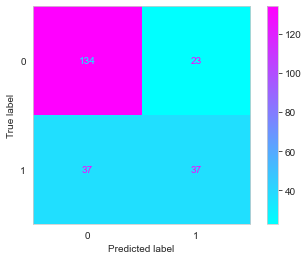

Accuracy: 67.68%


In [9]:
# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("Accuracy: " + str(round(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid)*100, 2)) + "%")

### Utilizando os dados sem tratá-los

Só para testar vamos ver como o modelo se sai caso não deletarmos os valores iguais a 0

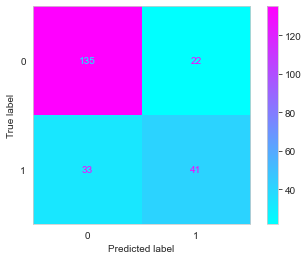

Accuracy: 70.7%


In [10]:
y = df.Outcome
X = df.drop(["Outcome"], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=RS)

print("Accuracy: " + str(round(score_dataset(X_train, X_valid, y_train, y_valid)*100, 2)) + "%")

Após os testes relizados podemos concluir que as previsões realizadas com os dados não tratados, ou seja, deixando os valores iguais a 0 que são impossíveis em uma situação real.

Caso essa opção não fosse a melhor, a melhor teria sido a de trocar os valores por 0 sem indicar que o valor foi modificado.

# Teste de diversos modelos

## RandomForestClassifier

Random Forest Classifier é um modelo de predição que utiliza diversas Decision Trees para determinarum valor (esse valor é a média dos valores definidos por cada uma das Decision Trees).

Uma boa forma de detectar, ou simplesmente testar, os diversos parametros que poderiam ser enviados para um modelo de previsão é utilizando RandomizerSearchCV, é um método que irá utilizar pelo menos X combinações possíveis dentro do intervalo de cada parametro enviado, assim um modelo um pouco mais otimizado pode aparecer.

Iremos utilizar os df sem tratamento, já que tivemos um resultado melhor sem tratá-los...

In [11]:
from sklearn.model_selection import RandomizedSearchCV

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=RS)

parameters = dict(
    n_estimators=range(1, 101),
    max_depth=range(1, 21),
)
model = RandomForestClassifier(random_state=RS)

random_search = RandomizedSearchCV(model, parameters, random_state=RS)
search = random_search.fit(X_train, y_train)
best_params = search.best_params_
best_params

{'n_estimators': 54, 'max_depth': 17}

Após ter coletado os melhores parametros para esse intervalo de dados, temos um modelo que possui a seguinte precisão e acuracia:

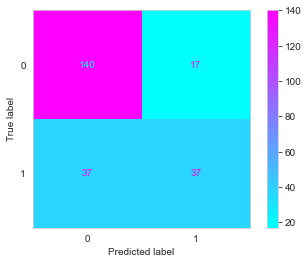

Accuracy: 73.81%
Precision: 68.52%


In [12]:
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score

plot_confusion_matrix(random_search, X_valid, y_valid, cmap = "cool")
plt.grid(False)
plt.show()

preds = random_search.predict(X_valid)

print("Accuracy: " + str(round(balanced_accuracy_score(preds, y_valid)*100, 2)) + "%")
print("Precision: " + str(round(precision_score(y_valid, preds, average='binary')*100, 2)) + "%")

## LogisticRegression

Agora vamos testar outro modelo existente no sklearn, o Logistic Regressor.

In [14]:
from sklearn.linear_model import LogisticRegression

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=RS)

parameters = dict(
    class_weight=["balanced", None],
    solver=["liblinear", "lbfgs"],
    max_iter=range(1, 100),
    warm_start=[True, False],
)
model = LogisticRegression(random_state=RS)

random_search = RandomizedSearchCV(model, parameters, random_state=RS)
search = random_search.fit(X_train, y_train)
best_params = search.best_params_
best_params

C:\Users\gabriel.paoli\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gabriel.paoli\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

{'warm_start': False,
 'solver': 'liblinear',
 'max_iter': 58,
 'class_weight': None}

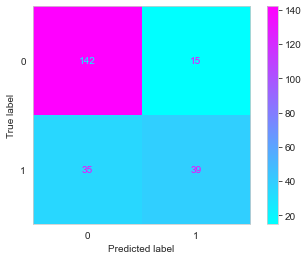

Accuracy: 76.22%
Precision: 72.22%


In [15]:
plot_confusion_matrix(random_search, X_valid, y_valid, cmap = "cool")
plt.grid(False)
plt.show()

preds = random_search.predict(X_valid)

print("Accuracy: " + str(round(balanced_accuracy_score(preds, y_valid)*100, 2)) + "%")
print("Precision: " + str(round(precision_score(y_valid, preds, average='binary')*100, 2)) + "%")

Como visto acima, o Logistic Regressor conseguiu um resultado bem melhor que o modelo anterior, e com a ajuda do RandomSearch conseguimos obter um resultado possivelmente bem melhor e muito mais rápido do que ir testando cada combinação manualmente.

## SVC

Nessa nova tentativa de obter um resultado ainda melhor vamos utilizar SVC, outro modelo existente dentro do SKlearn

In [19]:
from sklearn.svm import SVC

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=RS)

parameters = dict(
    shrinking=[False, True],
    class_weight=["balanced", None],
    gamma=["scale", "auto"],
)
model = SVC(random_state=RS)

random_search = RandomizedSearchCV(model, parameters, random_state=RS)
search = random_search.fit(X_train, y_train)
best_params = search.best_params_
best_params

C:\Users\gabriel.paoli\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'shrinking': False, 'gamma': 'scale', 'class_weight': None}

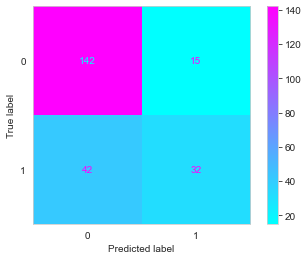

Accuracy: 72.63%
Precision: 68.09%


In [20]:
plot_confusion_matrix(random_search, X_valid, y_valid, cmap = "cool")
plt.grid(False)
plt.show()

preds = random_search.predict(X_valid)

print("Accuracy: " + str(round(balanced_accuracy_score(preds, y_valid)*100, 2)) + "%")
print("Precision: " + str(round(precision_score(y_valid, preds, average='binary')*100, 2)) + "%")

Com esses resultados podemos concluir algumas ideias sobre os modelos testados...

# Resumindo

## Resultados obtidos

Lembrando que esses testes foram realizados com RandomState = 0, caso esse 0 seja alterado, é possível que tenhamos resultados totalmente diferente, e caso você queira execitar todo o código de forma mais aleatória basta colocar o random state como *None*.

### RandomForestClassifier

Nesse teste tivemos os seguintes resultados:

- Accuracy: 73.81%
- Precisão: 68.52%

### LogisticRegressor

Nesse teste tivemos outros resultados:

- Accuracy: 76.22%
- Precisão: 72.22%

### SVC

Nesse teste tivemos resultados não tão positivos:

- Accuracy: 72.63%
- Precisão: 68.09%

# Counclusão final

Com todos esses testes que foram realizados, podemos concluir que o melhor modelo de predição é o LogisticRegressor, ele obteve resultados melhores, com maior acurácia e precisão, dessa forma poderiamos tentar explorar ainda mais esse modelo para tentar aprimorar seus resultados.